# Importing Libraries

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool,CatBoostClassifier
from sklearn.metrics import roc_auc_score as AUC
import optuna

In [117]:
train=pd.read_csv("train.csv")
original=pd.read_csv("machine failure.csv")
test=pd.read_csv("test.csv")

In [118]:
original.rename(columns = {'UDI':'id'}, inplace = True)

In [119]:
train=train.drop('id',axis=1)
test=test.drop('id',axis=1)
original=original.drop('id',axis=1)

# EDA

In [120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 13.5+ MB


In [121]:
train["Type"].unique()

array(['L', 'M', 'H'], dtype=object)

In [122]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Machine failure          10000 non-null  int64  
 8   TWF                      10000 non-null  int64  
 9   HDF                      10000 non-null  int64  
 10  PWF                      10000 non-null  int64  
 11  OSF                      10000 non-null  int64  
 12  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1015.8+ KB


Text(0.5, 1.0, 'Original')

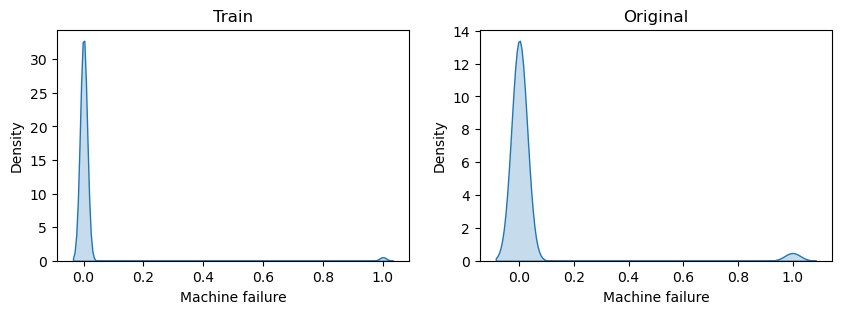

In [123]:
fig,axes=plt.subplots(1,2,figsize=(10,3))
sns.kdeplot(ax=axes[0],x="Machine failure",data=train,fill=True).set_title("Train")
sns.kdeplot(ax=axes[1],x="Machine failure",data=original,fill=True).set_title("Original")

<Axes: >

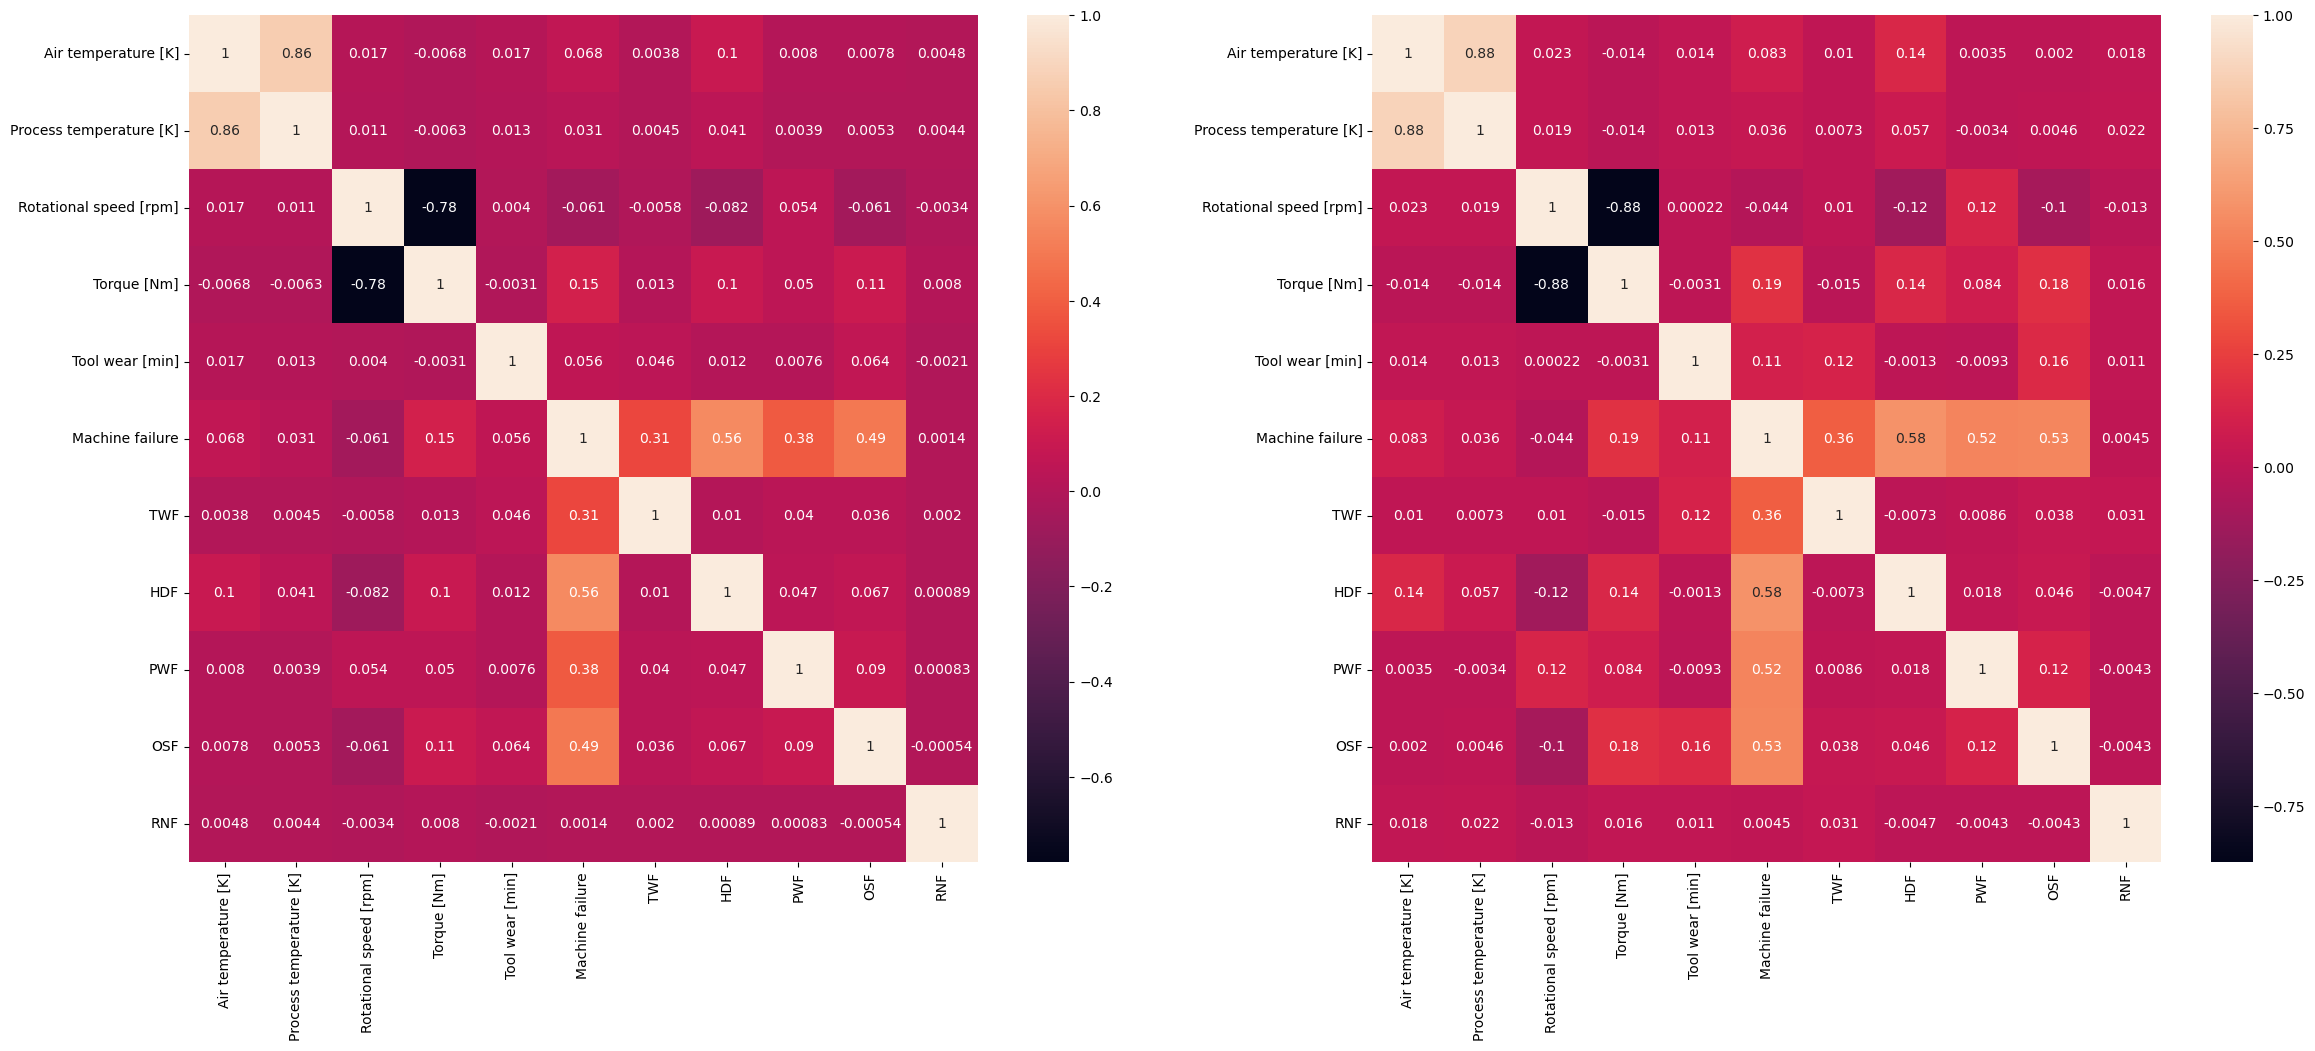

In [124]:
fig,axes=plt.subplots(1,2,figsize=(28,11))
sns.heatmap(ax=axes[0],data=train.corr(numeric_only=True),annot=True)
sns.heatmap(ax=axes[1],data=original.corr(numeric_only=True),annot=True)

# Expanding Dataset

In [125]:
train=pd.concat([train, original], axis = 0).reset_index(drop = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146429 entries, 0 to 146428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               146429 non-null  object 
 1   Type                     146429 non-null  object 
 2   Air temperature [K]      146429 non-null  float64
 3   Process temperature [K]  146429 non-null  float64
 4   Rotational speed [rpm]   146429 non-null  int64  
 5   Torque [Nm]              146429 non-null  float64
 6   Tool wear [min]          146429 non-null  int64  
 7   Machine failure          146429 non-null  int64  
 8   TWF                      146429 non-null  int64  
 9   HDF                      146429 non-null  int64  
 10  PWF                      146429 non-null  int64  
 11  OSF                      146429 non-null  int64  
 12  RNF                      146429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 14.5+ MB


<Axes: >

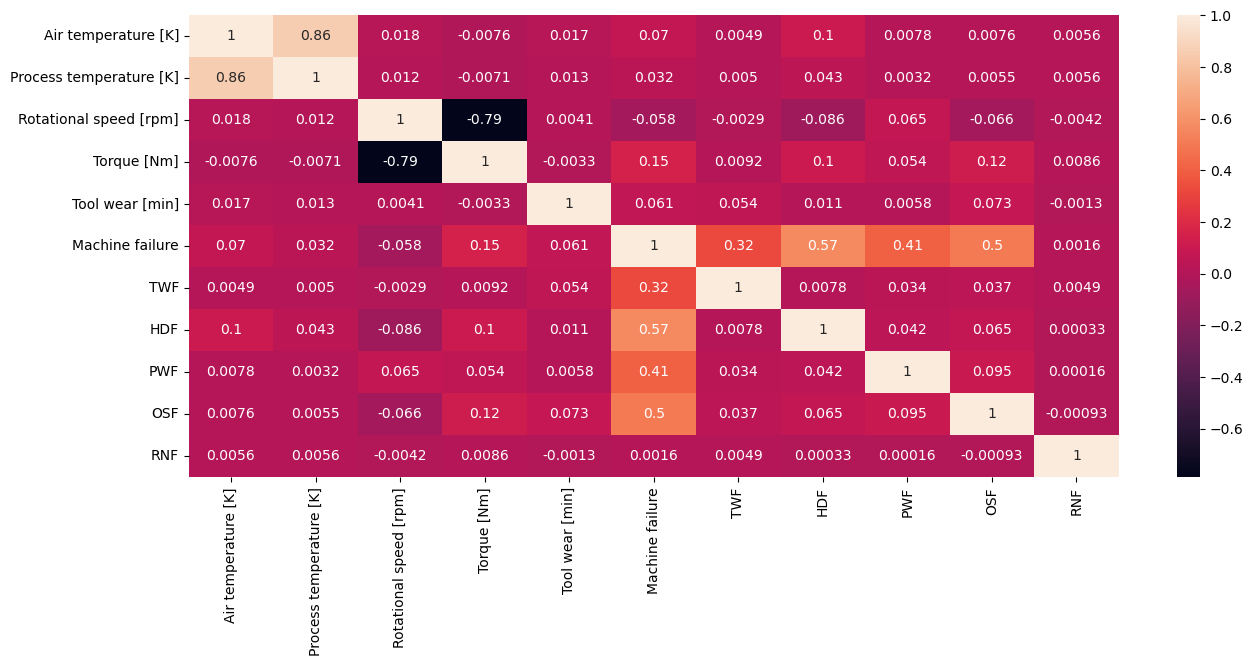

In [126]:
plt.figure(figsize=(15,6))
sns.heatmap(data=train.corr(numeric_only=True),annot=True)

# Data Augumentation

In [127]:
train.dtypes

Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [128]:
train.columns.tolist()

['Product ID',
 'Type',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [129]:
train.select_dtypes(include=['float64','int32','int64']).columns.tolist()

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [130]:
train

Product ID Type  Air temperature [K]  Process temperature [K]  \
0          L50096    L                300.6                    309.6   
1          M20343    M                302.6                    312.1   
2          L49454    L                299.3                    308.5   
3          L53355    L                301.0                    310.9   
4          M24050    M                298.0                    309.0   
...           ...  ...                  ...                      ...   
146424     M24855    M                298.8                    308.4   
146425     H39410    H                298.9                    308.4   
146426     M24857    M                299.0                    308.6   
146427     H39412    H                299.0                    308.7   
146428     M24859    M                299.0                    308.7   

        Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
0                         1596         36.1              140                0   
1                         1759         29.1              200                0   
2                         1805         26.5               25                0   
3                         1524         44.3              197                0   
4                         1641         35.4               34                0   
...                        ...          ...              ...              ...   
146424                    1604         29.5               14                0   
146425                    1632         31.8               17                0   
146426                    1645         33.4               22                0   
146427                    1408         48.5               25                0   
146428                    1500         40.2               30                0   

        TWF  HDF  PWF  OSF  RNF  
0         0    0    0    0    0  
1         0    0    0    0    0  
2         0    0    0    0    0  
3         0    0    0    0    0  
4         0    0    0    0    0  
...     ...  ...  ...  ...  ...  
146424    0    0    0    0    0  
146425    0    0    0    0    0  
146426    0    0    0    0    0  
146427    0    0    0    0    0  
146428    0    0    0    0    0  

[146429 rows x 13 columns]

# Model Creation

In [131]:
X=train.drop(columns=["Machine failure"])
Y=train['Machine failure']

In [132]:
X

Product ID Type  Air temperature [K]  Process temperature [K]  \
0          L50096    L                300.6                    309.6   
1          M20343    M                302.6                    312.1   
2          L49454    L                299.3                    308.5   
3          L53355    L                301.0                    310.9   
4          M24050    M                298.0                    309.0   
...           ...  ...                  ...                      ...   
146424     M24855    M                298.8                    308.4   
146425     H39410    H                298.9                    308.4   
146426     M24857    M                299.0                    308.6   
146427     H39412    H                299.0                    308.7   
146428     M24859    M                299.0                    308.7   

        Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  PWF  \
0                         1596         36.1              140    0    0    0   
1                         1759         29.1              200    0    0    0   
2                         1805         26.5               25    0    0    0   
3                         1524         44.3              197    0    0    0   
4                         1641         35.4               34    0    0    0   
...                        ...          ...              ...  ...  ...  ...   
146424                    1604         29.5               14    0    0    0   
146425                    1632         31.8               17    0    0    0   
146426                    1645         33.4               22    0    0    0   
146427                    1408         48.5               25    0    0    0   
146428                    1500         40.2               30    0    0    0   

        OSF  RNF  
0         0    0  
1         0    0  
2         0    0  
3         0    0  
4         0    0  
...     ...  ...  
146424    0    0  
146425    0    0  
146426    0    0  
146427    0    0  
146428    0    0  

[146429 rows x 12 columns]

In [133]:
Y

0         0
1         0
2         0
3         0
4         0
         ..
146424    0
146425    0
146426    0
146427    0
146428    0
Name: Machine failure, Length: 146429, dtype: int64

In [134]:
params ={'loss_function': 'Logloss','eval_metric': 'AUC','random_seed': 19970507,'learning_rate': 0.2373428829418096, 'iterations': 2000, 'depth': 6, 'subsample': 0.5227705614428807}
feature_names = ['Product ID','Type','Air temperature [K]','Process temperature [K]',
                 'Rotational speed [rpm]','Torque [Nm]','Tool wear [min]','TWF','HDF','PWF','OSF','RNF']
train_pool = Pool(X.to_numpy(), Y.to_numpy(), feature_names = feature_names, cat_features = ['Product ID', 'Type'])
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=train_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [135]:
test_pool = Pool(test.to_numpy(), feature_names=feature_names, cat_features = ['Product ID', 'Type'])
pred = model.predict_proba(test_pool)[:,1]

In [136]:
print("Train Score: {}".format(AUC(train["Machine failure"],model.predict(train.drop(columns=["Machine failure"])))))

Train Score: 0.9437832729135522


In [137]:
df=pd.DataFrame()
df["Machine failure"]=pred
df.index = 136428 + df.index
df.index+=1
df.index.name='id'
df

Machine failure
id                     
136429         0.000522
136430         0.000047
136431         0.000041
136432         0.000586
136433         0.000056
...                 ...
227378         0.000378
227379         0.003140
227380         0.000002
227381         0.000846
227382         0.000154

[90954 rows x 1 columns]

In [138]:
df.to_csv('submission.csv', header=True)